# Tasks

## P 11.1: Find a sequential dataset and apply an RNN or LSTM model to the dataset. The quality of your solution and the accuracy your model produces will affect your mark. So, try to get the best accuracy possible (10%).

## NOTE: You should comment on your code and explain what each part of the code does.

In [176]:
############# WRITE YOUR CODE IN THIS CELL (IF APPLICABLE)  ####################
#imports
import pandas as pd
import seaborn as sns
import numpy as np
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob
import textblob
from textblob import Word
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report

In [177]:
#Dataset gotten from - https://archive.ics.uci.edu/dataset/228/sms+spam+collection
df = pd.read_csv("/content/sms_spam.csv", sep="\t", header=None, names=['label', 'message'])

In [178]:
#printing out first 5 of my dataset
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [179]:
#Checking for how many unique labels are present
df["label"].value_counts()

,count
label,
ham,4825
spam,747


In [180]:
#checking for null values
df.isnull().sum()

,0
label,0
message,0


In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [182]:
df.shape

(5572, 2)

In [183]:
#There is a massive difference in the class, there is a lot more ham than spam so im only using the same amount of spam available for ham too
spam_df = df[df['label'] == 'spam']
ham_df = df[df['label'] == 'ham']

#Downsample the majority class to match the minority class size
ham_df_downsampled = ham_df.sample(n=len(spam_df), random_state=20)

#Joined the balanced data
df_balanced = pd.concat([spam_df, ham_df_downsampled])

#Shuffled the dataset
df_balanced = df_balanced.sample(frac=1, random_state=30).reset_index(drop=True)

In [184]:
#making sure the message column is in lower case
df_balanced['message'] = df_balanced['message'].apply(lambda x: " ".join(x.lower()  for x in x.split()))

In [185]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [186]:
# Removing punctuation using string module
df_balanced['message'] = df_balanced.message.apply(lambda x:''.join(i for i in x if i not in string.punctuation))

In [187]:
# Removing punctuation using regular expression
df_balanced['message'] = df_balanced.message.apply(lambda x:''.join(re.findall(r'[a-zA-Z+" "]',x)))

In [188]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
#removing stopwords
allstopwords = stopwords.words('english')
df_balanced["message"] = df_balanced.message.apply(lambda x: " ".join(i for i in x.split() if i not in allstopwords))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [189]:
#lemmatisation
df_balanced['message'] = df_balanced['message'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [190]:
# frequency
all_words = []
for sentence in df_balanced['message']:
    all_words.extend(sentence.split())
nltk.FreqDist(all_words)


FreqDist({'call': 393, 'u': 308, 'free': 222, 'ur': 185, 'txt': 156, 'text': 148, 'mobile': 139, 'get': 132, 'stop': 124, 'claim': 115, ...})

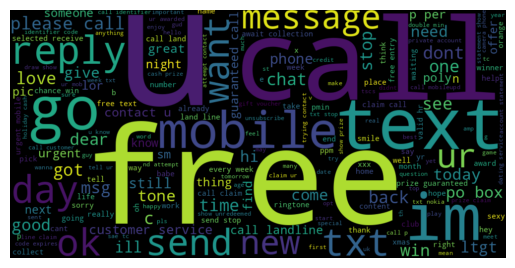

In [191]:
# word cloud
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
words = []
for message in df_balanced['message']:
    words.extend([word for word in message.split() if word not in STOPWORDS])

wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


<Axes: xlabel='label', ylabel='count'>

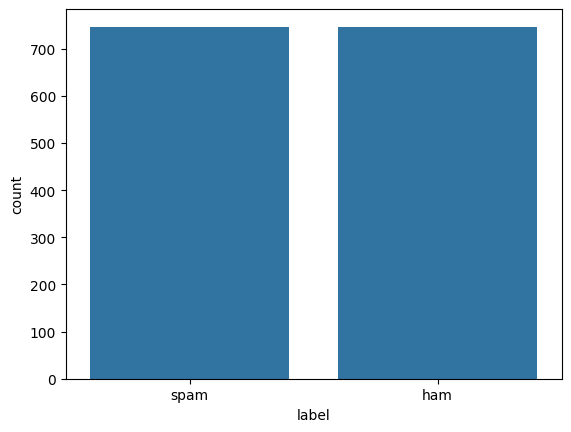

In [192]:
sns.countplot(x=df_balanced["label"])
#Before:Quite a large disparity between ham and spam, huge dataset imbalance

In [193]:
# Extracting input and output
X=df_balanced['message']
y=df_balanced['label']

In [194]:
le = LabelEncoder()
y = le.fit_transform(y)
#0 = ham, 1 = spam

In [195]:
#splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [196]:
#Tokenisation
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [197]:
#Padding sequences because of LSTM, it needs fixed-length input
max_len = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Vocabulary size for Embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [198]:
#Building the LSTM model
model = Sequential()
# Embedding layer turns integer word indices into dense vectors
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len))
# LSTM layer to learn sequential patterns
model.add(LSTM(units=64, dropout = 0.2))
# Output layer with sigmoid for binary classification
model.add(Dense(1, activation='sigmoid'))
#compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=30, batch_size=32)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.5230 - loss: 0.6933 - val_accuracy: 0.4448 - val_loss: 0.6957
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5311 - loss: 0.6917 - val_accuracy: 0.5552 - val_loss: 0.6931
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4993 - loss: 0.6936 - val_accuracy: 0.4448 - val_loss: 0.6968
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5235 - loss: 0.6923 - val_accuracy: 0.4448 - val_loss: 0.6954
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5281 - loss: 0.6930 - val_accuracy: 0.4448 - val_loss: 0.6946
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5104 - loss: 0.6932 - val_accuracy: 0.4448 - val_loss: 0.6968
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5183 - loss: 0.6924 - val_accuracy: 0.4448 - val_loss: 0.6915
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7843 - loss: 0.4704 - val_accuracy: 0.8963 - val_loss: 0.

In [ ]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9170 - loss: 0.3007
Test Accuracy: 0.9164


In [200]:

y_pred_probs = model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       166
           1       0.96      0.85      0.90       133

    accuracy                           0.92       299
   macro avg       0.92      0.91      0.91       299
weighted avg       0.92      0.92      0.92       299



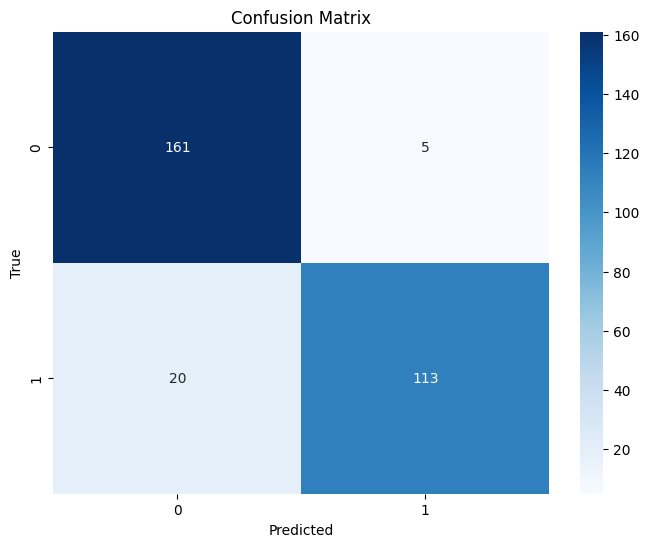

In [201]:
#Printing classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
#😊Accuracy of 92%

In [202]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots training and validation loss & accuracy from a Keras model history object.

    Args:
        history: Keras History object from model.fit()
    """
    # Create subplots for Loss and Accuracy
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Loss Plot
    ax[0].plot(history.history['loss'], label='Training Loss', color='blue')
    ax[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].legend()

    # Accuracy Plot
    ax[1].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].legend()

    # Show the plots
    plt.show()


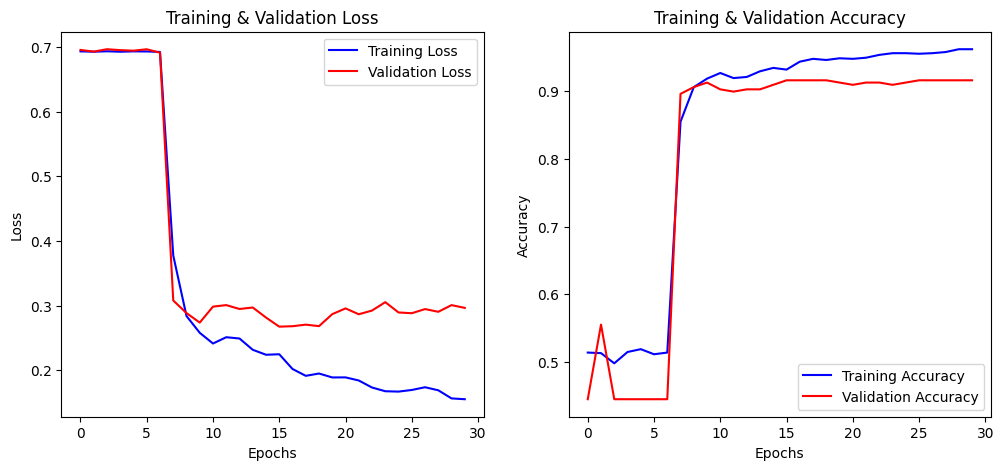

In [203]:
# Plot training performance
plot_training_history(history)